Projet Maths-Info
===============

Myrtille DAVID et Bérénice SINOPOLI--PAL




In [2]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Amorce
------

D'après le théorème des valeurs intermédiaires, si la fonction $f_{1}:x \mapsto f(x,0)$ est continue et que $f(0,0)\leq c\leq f(1,0)$ alors il existe $t\in [0,1]$ tel que $f(t,0)=c$.
Plusieurs algorithmes sont envisageables pour trouver ce t. Comme la méthode de Newton ne fonctionne pas avec toutes les fonctions, on a préféré ici une méthode par dichotomie.

In [3]:
def find_seed(g, c=0, eps=2**(-26)):
    def f(x,y):
        return g(x,y)-c
    a,b=0,1
    m=(a+b)/2
    
    if f(0,a)*f(0,b)<0 :
        while abs(f(0,m))>eps:
            if f(0,a)*f(0,m)<0:
                b = m
            elif f(0,b)*f(0,m)<0:
                a = m
            m = (a+b)/2
    
        return m
    elif f(0,a)==0:
        return a
    elif f(0,b)==0:
        return b
    else :
        return None

Propagation : première version
-------------

Voici une première ébauche de notre programme simple_contour. On utilise ici le fait que le gradient est en tout point orthogonal aux lignes de niveau. 

**Principe :** on définit une fonction grad_f qui calcule le gradient de la fonction en un point donné. On trace ensuite la ligne de niveau point par point : on calcule le gradient, on ajoute un point dans la direction orthogonale éloigné d'une distance $\delta$ du précédent.

**Le problème majeur de ce programme :** à chaque fois que l'on ajoute un point, l'erreur s'accumule et on peut s'éloigner beaucoup de la ligne de niveau initiale.

In [4]:
def simple_contour_brouillon(f, c=0.0, delta=0.01):
    
    def grad_f(x,y):
        g = autograd.grad
        return np.r_[g(f,0)(x,y), g(f,1)(x,y)]
        
    x=[]
    y=[]
    
    a = find_seed(f,c)
    if a is None :
        return x,y
    else:
        x.append(0.0)
        y.append(a)
        
    while len(x)<1000: #quelle condition pour arrêter de tracer la ligne de niveau ?
        gr = grad_f(x[-1],y[-1])
        d = [gr[1],-gr[0]]
        L=np.sqrt(d[0]**2+d[1]**2)
        d[0]=d[0]*delta/L
        d[1]=d[1]*delta/L
        
        x.append(x[-1]+d[0])
        y.append(y[-1]+d[1])
        print(f(x[-1],y[-1]))
        
    plt.plot(x,y)
    plt.show()
    return x,y
    

Propagation : version finale
------------------

Ce programme fonctionne selon le même principe que le précédent. Voici les ajustements proposés : 

**Correction de l'erreur :** à chaque fois que l'on calcule un nouveau point, on vérifie qu'il n'est pas trop éloigné de la ligne de niveau souhaitée en comparant $f(x,y)$ à $c$. Si $\left | f(x,y)-c) \right |> 10^{-4}$, alors on se "déplace" dans la direction donnée par le gradient (dans le sens du gradient ou le sens opposé selon le signe de la différence) pour se rapprocher de la ligne de niveau. A chaque itération, on vérifie que la différence $\left | f(x,y)-c) \right |> 10^{-4}$ n'augmente pas ; sinon, on sort de la boucle.

**Quand arrêter de tracer la ligne de niveau ?** 
Plusieurs cas de figure sont envisageables :
- soit la ligne de niveau rencontre un des bords du carré; on s'arrête.
- soit la ligne de niveau ne rencontre jamais de bord; dans ce cas, pour éviter de calculer indéfiniment de nouveaux points, on choisit arbitrairement de limiter le nombre de points de la ligne à 10000.

In [5]:
    
def simple_contour(f, c=0.0, delta=0.01):
    
    def grad_f(x,y): #on définit la fonction gradient
        g = autograd.grad
        return np.r_[g(f,0)(x,y), g(f,1)(x,y)]
        
    x=[]
    y=[]
    
    a = find_seed(f,c) #on cherche le premier point à l'aide du programme find_seed
    
    if a is None :
        return x,y
    else:
        x.append(0.0)
        y.append(a)
        
    while len(x)<10000: #on limite le nombre de points au cas où la ligne de niveau n'atteigne jamais de bord du carré
        gr = grad_f(x[-1],y[-1]) #on calcule le gradient du dernier point trouvé
        d = [gr[1],-gr[0]] #on calcule le vecteur orthogonal
        L=np.sqrt(d[0]**2+d[1]**2)
        d[0]=d[0]*delta/L #on change la norme de d pour qu'elle soit proche de delta
        d[1]=d[1]*delta/L
        
        x2=x[-1]+d[0] #on calcule le nouveau point
        y2=y[-1]+d[1]
        
        différence= f(x2,y2)-c #on vérifie que le nouveau point calculé ne s'éloigne pas trop de la ligne de niveau
        while abs(différence)>10**(-4):
            différence_ref=différence
            t=grad_f(x2,y2)
            norme_t=np.sqrt(t[0]**2+t[1]**2)
            
            if différence>0: #si f(x2,y2)>c alors on se déplace dans le sens opposé au gradient
                x3=x2-t[0]/norme_t*(delta/50)
                y3=y2-t[0]/norme_t*(delta/50)
            else: #sinon on se déplace dans le sens du gradient
                x3=x2+t[0]/norme_t*(delta/50)
                y3=y2+t[0]/norme_t*(delta/50)
            différence= f(x3,y3)-c
            
            if différence>différence_ref: #si on s'éloigne de la ligne de niveau, on arrête la correction
                break
                
            x2=x3
            y2=y3
                
        
        x.append(x2)
        y.append(y2)
        
        if (abs(x[-1]-1)<delta) or ((abs(x[-1])<delta) and len(x)>10) or (abs(y[-1]-1)<delta) or (abs(y[-1])<delta): #on s'arrête quand on atteint les bords
            break
        
    return(x,y)
    

Test de simple_contour
-------------

On teste simple_contour sur plusieurs fonctions définies ci-dessous. La fonction simple_contour2 est la même que celle ci dessus sauf qu'elle permet de plotter le fragment calculé. On l'utilise pour visualiser et tester le programme maintenant mais c'est simple_contour qui est réutilisé par la suite.

In [10]:
def h2(x,y):
    return x+y**2-0.47
def h3(x,y):
    return x**2+y**2

In [7]:
def simple_contour2(f, c=0.0, delta=0.01):
    
    def grad_f(x,y): #on définit la fonction gradient
        g = autograd.grad
        return np.r_[g(f,0)(x,y), g(f,1)(x,y)]
        
    x=[]
    y=[]
    
    a = find_seed(f,c) #on cherche le premier point à l'aide du programme find_seed
    
    if a is None :
        return x,y
    else:
        x.append(0.0)
        y.append(a)
        
    while len(x)<10000: #on limite le nombre de points au cas où la ligne de niveau n'atteigne jamais de bord du carré
        gr = grad_f(x[-1],y[-1]) #on calcule le gradient du dernier point trouvé
        d = [gr[1],-gr[0]] #on calcule le vecteur orthogonal
        L=np.sqrt(d[0]**2+d[1]**2)
        d[0]=d[0]*delta/L #on change la norme de d pour qu'elle soit proche de delta
        d[1]=d[1]*delta/L
        
        x2=x[-1]+d[0] #on calcule le nouveau point
        y2=y[-1]+d[1]
        
        différence= f(x2,y2)-c #on vérifie que le nouveau point calculé ne s'éloigne pas trop de la ligne de niveau
        while abs(différence)>10**(-4):
            différence_ref=différence
            t=grad_f(x2,y2)
            norme_t=np.sqrt(t[0]**2+t[1]**2)
            
            if différence>0: #si f(x2,y2)>c alors on se déplace dans le sens opposé au gradient
                x3=x2-t[0]/norme_t*(delta/50)
                y3=y2-t[0]/norme_t*(delta/50)
            else: #sinon on se déplace dans le sens du gradient
                x3=x2+t[0]/norme_t*(delta/50)
                y3=y2+t[0]/norme_t*(delta/50)
            différence= f(x3,y3)-c
            
            if différence>différence_ref: #si on s'éloigne de la ligne de niveau, on arrête la correction
                break
                
            x2=x3
            y2=y3
                
        
        x.append(x2)
        y.append(y2)
        
        if (abs(x[-1]-1)<delta) or ((abs(x[-1])<delta) and len(x)>10) or (abs(y[-1]-1)<delta) or (abs(y[-1])<delta): #on s'arrête quand on atteint les bords
            break
        
    plt.plot(x,y, label=c)
    return(x,y)
    

In [ ]:
simple_contour2(h2,-0.25)
simple_contour2(h2,0.0)
simple_contour2(h2,0.25)
simple_contour2(h2,0.35)
simple_contour2(h2,0.45)
plt.legend()
plt.show()

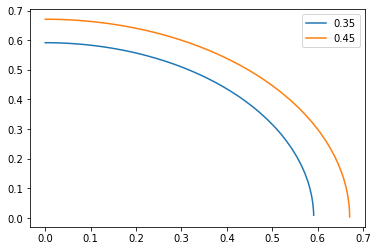

In [8]:
simple_contour2(h3,0.35)
simple_contour2(h3,0.45)
plt.legend()
plt.show()

Contour complexe
------

On utilise dans cette dernière partie la fonction simple_contour au sein de contour_complexe pour tracer des lignes de niveau sur une zone plus étendue.

In [6]:

# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour

def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

Test sur plusieurs fonctions
-----------

On utilise la fonction $h2$ définie plus haut et la fonction $h$ définie ci-dessous.

In [7]:
def f(x,y):
    return np.exp((-x**2)-(y**2))
    
def g(x,y):
    return np.exp(-(x-1)**2-(y-1)**2)
    
def h(x,y):
    return 2*(f(x,y)-g(x,y))

def i(x,y):
    return x**4+y**4-0.4


Test de la fonction $h2$ sur l'intervalle $\left [ 0;1 \right ]\times \left [ 0;2 \right ]$

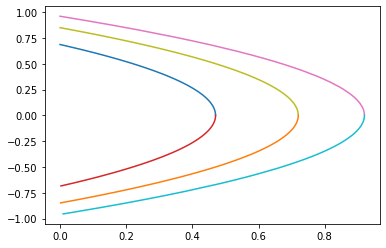

In [11]:
xs=[0.0,1.0]
ys=[0.0,1.0,2.0]

tc=[0.0,0.25,0.45]

for c in tc:
    level_curves = contour(h2,c, xs, ys) 
    for x, y in level_curves:
        plt.plot(x, y)

plt.show()

Test de la fonction $h$ sur l'intervalle $\left [ 0;2 \right ]\times \left [ 1;2 \right ]$

In [ ]:
xs=[0.0,1.0,2.0]
ys=[1.0,2.0]

tc=[-1.5,-1.0,-0.8]

for c in tc:
    level_curves = contour(h,c, xs, ys) 
    for x, y in level_curves:
        plt.plot(x, y)

plt.show()

Test de la fonction $i$ sur l'intervalle $\left [ -2;2 \right ]\times \left [ -2;2 \right ]$

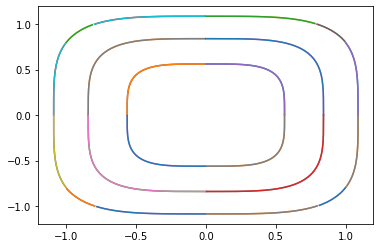

In [8]:
xs=[-2.0,-1.0,0.0,1.0,2.0]
ys=[-2.0,-1.0,0.0,1.0,2.0]

tc=[0.1,-0.3,1.0]

for c in tc:
    level_curves = contour(i,c, xs, ys) 
    for x, y in level_curves:
        plt.plot(x, y)

plt.show()